#### I. Paquetes específicos probados

# Numerical development to resolve Time-Dependent Schrödinger equation through eigenvalue problem

## 1. Import modules with useful functions, parameters, and algorithms.

In [1]:
println("Number of threads = ", Threads.nthreads());

Number of threads = 4


In [2]:
name_code = "03_Code_auxiliary_tests";

In [4]:
# If we have problems with gridap_makie folder probably running the next command we resolve that
Pkg.resolve()
Pkg.instantiate()

  No Changes to `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie/Project.toml`
  No Changes to `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie/Manifest.toml`


In [3]:
include("../modules/module_schrodinger_equation_eigenproblem.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie`


## 2. Setting grid properties

Set unit convertion constants

In [4]:
Bohr_radius_meter=5.29177210903e−11;                        # [m]
Angstrom_to_meter=1e−10;                                    # [m/Å]
Angstrom_to_au=Angstrom_to_meter*(1.0/Bohr_radius_meter);   # [au/Å]
Femtoseconds_to_au=(1.0/0.0218884);                         # [au/fs]

## 5. Resolve the 2D problem

### 5.1. Resolve eigenvalue problem

Define mesh properties and create the mesh

In [5]:
dom_2D=(-12.0*Angstrom_to_au,12.0*Angstrom_to_au,-4.9*Angstrom_to_au*γ,4.9*Angstrom_to_au*γ);   # cantidad de FE y dominio espacial
n_1D_r=50;n_1D_R=50;    # cantidad de FE por dimension (cantidad de intervalos)
ΔrH=abs(dom_2D[2]-dom_2D[1])/(n_1D_r-1); ΔRH=abs(dom_2D[4]-dom_2D[3])/(n_1D_R-1)                        # tamaño del elemento 2D
partition_2D=(n_1D_r,n_1D_R);                               # grilla de tamaño n²
model_2D=CartesianDiscreteModel(dom_2D,partition_2D);   # creamos modelo con elementos cartesianos
println("ΔrH=$(round(ΔrH/Angstrom_to_au,digits=2))[Å]; ΔRH=$(round(ΔRH/Angstrom_to_au,digits=2))[Å]; ΔχH=$(round(ΔRH/(Angstrom_to_au*γ),digits=2))")
println("n_1D_r*n_1D_R=$(n_1D_r*n_1D_R) FE")

ΔrH=0.49[Å]; ΔRH=8.94[Å]; ΔχH=0.2
n_1D_r*n_1D_R=2500 FE


In [14]:
writevtk(model_2D,path_models*"CartesianDiscreteModel");

define boundary conditions

In [6]:
dirichlet_values_2D=(0.0+im*0.0);        # condiciones de contorno de tipo fulldirichlet
dirichlet_tags_2D="boundary";

In [7]:
Ω_2D,dΩ_2D,Γ_2D,dΓ_2D=measures(model_2D,3,dirichlet_tags_2D);
reffe_2D=ReferenceFE(lagrangian,Float64,2);

Define bilinear forms and FE spaces

In [119]:
VHre_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
UHre_2D=TrialFESpace(VHre_2D,dirichlet_values_2D);

R₁=-5.0*Angstrom_to_au;R₂=5.0*Angstrom_to_au;Rf=1.5*Angstrom_to_au;

set_Rc_value=1;
(set_Rc_value==1) ? Rc=1.5*Angstrom_to_au : Rc=5.0*Angstrom_to_au;

pH_2D,qH_2D,rH_2D=eigenvalue_problem_functions((R₁,R₂,Rc,Rf);switch_potential = "Electron_Nuclear_Potential_2D")
aH_2D,bH_2D=bilineal_forms(pH_2D,qH_2D,rH_2D,dΩ_2D);

Set Electron-Nuclear potential


Solve eigenvalue problem

In [120]:
nevH=15;
probH_2D=EigenProblem(aH_2D,bH_2D,UHre_2D,VHre_2D;nev=nevH,tol=10^(-12),maxiter=1000,explicittransform=:none,sigma=-10.0);

In [121]:
ϵH_2D,ϕH_2D=solve(probH_2D);

Chequeamos ortogonalidad de los autoestados

In [13]:
@benchmark OrthoCheck(ϕH_2D,UHre_2D,dΩ_2D)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  912.491 ms …    1.311 s  ┊ GC (min … max): 1.04% … 1.16%
 Time  (median):        1.154 s               ┊ GC (median):    0.81%
 Time  (mean ± σ):      1.104 s ± 166.236 ms  ┊ GC (mean ± σ):  0.62% ± 0.56%

  █     █                             █    █                  █  
  █▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  912 ms           Histogram: frequency by time          1.31 s <

 Memory estimate: 87.67 MiB, allocs estimate: 458791.

In [14]:
@benchmark OrthoCheck_v2(ϕH_2D,UHre_2D,dΩ_2D)

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  463.857 ms … 603.803 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     534.430 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   529.366 ms ±  53.348 ms  ┊ GC (mean ± σ):  0.52% ± 0.82%

  █  ██     █       █                        █ █ █  █         █  
  █▁▁██▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁█▁▁█▁▁▁▁▁▁▁▁▁█ ▁
  464 ms           Histogram: frequency by time          604 ms <

 Memory estimate: 45.25 MiB, allocs estimate: 232464.

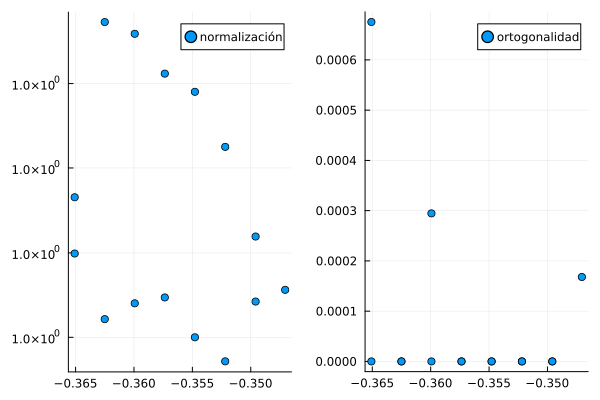

In [122]:
plot1=scatter(real(ϵH_2D),normalization_eigenstates(ϕH_2D,UHre_2D,dΩ_2D),label="normalización")
plot2=scatter(real(ϵH_2D),OrthoCheck_v2(ϕH_2D,UHre_2D,dΩ_2D),label="ortogonalidad")

display(plot(plot1,plot2,layout=2))

In [69]:
# Escribimos autovectores para visualizar externamente
write_data=true;
if write_data
    for i in 1:10#nevH
        writevtk(Ω_2D,path_images*"eigenprob_2D_Rcvalue$(set_Rc_value)_num$(i)",cellfields=["ρ_eigenstates" => real((ϕH_2D[i]')*ϕH_2D[i])]);
    end
end

In [123]:
S_2D=TimeIndependet_Diff_Shannon_Entropy(ϕH_2D,UHre_2D,dΩ_2D);

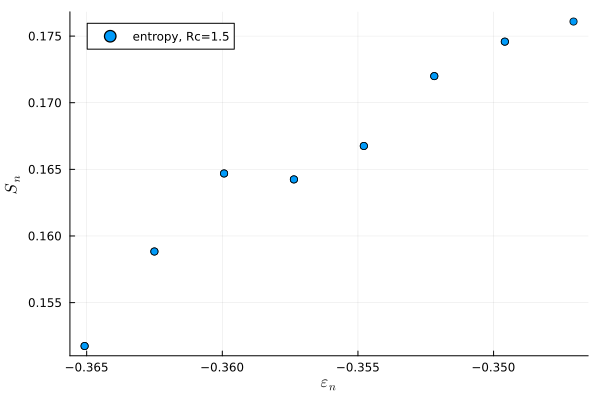

In [124]:
scatter(real(ϵH_2D),S_2D./γ,xlabel="\$\\epsilon_n\$",ylabel="\$S_n\$",label="entropy, Rc=$(round(Rc/Angstrom_to_au;digits=2))")

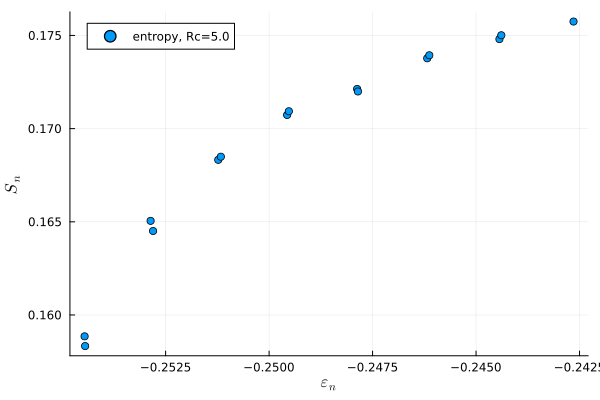

In [71]:
scatter(real(ϵH_2D),S_2D./γ,xlabel="\$\\epsilon_n\$",ylabel="\$S_n\$",label="entropy, Rc=$(Rc/Angstrom_to_au)")

### 5.2. Resolve time-dependent Schrödinger equation

#### 5.2.1. Create initial condition

In [20]:
function gaussian_factor(x,χ₀,β)
    return exp(-β*pow((x[2]*(1.0/γ)-χ₀),2));
end

function create_initial_state_2D(ϕₙ,n,Ω,dΩ,χ₀,β)
    𝛹ₓ₀ = CellField(x->gaussian_factor(x,χ₀,β),Ω)*ϕₙ[n];
    𝛹ₓ₀=𝛹ₓ₀*(1.0/norm_L2(𝛹ₓ₀,dΩ));
    return 𝛹ₓ₀;
end

create_initial_state_2D (generic function with 1 method)

In [125]:
β=3.57*(1.0/(Angstrom_to_au*Angstrom_to_au));
set_Rc_value==1 ? R₀=-3.5*Angstrom_to_au : R₀=-1.5*Angstrom_to_au;
𝛹ₓ₀=create_initial_state_2D(ϕH_2D,2,Ω_2D,dΩ_2D,R₀,β);

In [73]:
writevtk(Ω_2D,path_images*"initial_condition_Rcvalue$(set_Rc_value)",cellfields=["ρₓ₀" => real((𝛹ₓ₀)'*𝛹ₓ₀)]);

Chequeamos convergencia para el método de evolución temporal, la idea acá es computar los coeficientes de descomposición lineal del estado inicial en los autoestados del hamiltoniano.

Teniendo en cuenta que

\begin{array}{l}
    \ket{\psi ^{( n)}( t=0)} =\sum _{j=1}^{n} c_{j}\ket{\phi _{j}} \Rightarrow \ket{\psi ^{( n)}( t)} =\sum _{j=1}^{n} c_{j}\exp\left( -\frac{i}{\hbar } \epsilon _{j} t\right)\ket{\phi _{j}} ;\ \bra{\phi _{i}}\ket{\phi _{j}} =\delta _{ij}\\
    \bra{\psi ^{( n)}( t)}\ket{\psi ^{( n+q)}( t)} =\left[\sum _{j=1}^{n}( c_{j})^{*}\exp\left(\frac{i}{\hbar } \epsilon _{j} t\right)\bra{\phi _{j}}\right]\left[\sum _{k=1}^{( n+q)} c_{k}\exp\left( -\frac{i}{\hbar } \epsilon _{k} t\right)\ket{\phi _{k}}\right] = \sum _{j=1}^{n}( c_{j})^{*} c_{j}\stackrel{?}{=} 1
\end{array}

Entonces, ploteamos qué tanto se separa esta sumatoria del valor de la unidad.

In [126]:
CheckConvergenceVector=CheckConvergence(𝛹ₓ₀,ϕH_2D,UHre_2D,dΩ_2D);
println("$(CheckConvergenceVector[end])")

0.9993147253682336


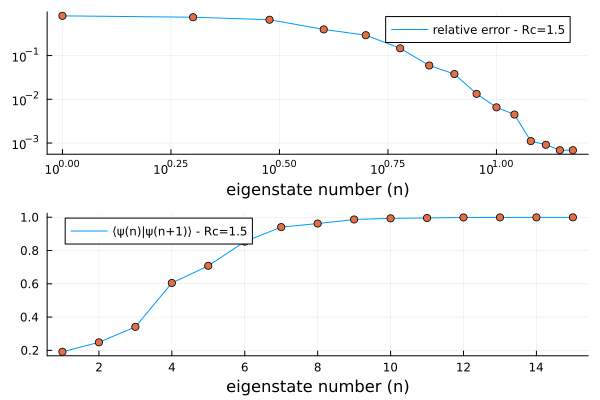

In [127]:
plot1=plot()
plot2=plot!(plot1,abs.(1.0 .- CheckConvergenceVector) ./ 1.0,label="relative error - Rc=$(round(Rc/Angstrom_to_au;digits=2))")
plot2=scatter!(plot1,abs.(1.0 .- CheckConvergenceVector) ./ 1.0,label="")
plot2=plot!(xlabel="eigenstate number (n)",ylabel="",yaxis=:log,xaxis=:log)

plot3=plot()
plot4=plot!(plot3,CheckConvergenceVector,label="⟨ψ(n)|ψ(n+1)⟩ - Rc=$(round(Rc/Angstrom_to_au;digits=2))")
plot4=scatter!(plot3,CheckConvergenceVector,label="")
plot4=plot!(xlabel="eigenstate number (n)",ylabel="")

display(plot(plot2,plot4,layout=(2,1)))

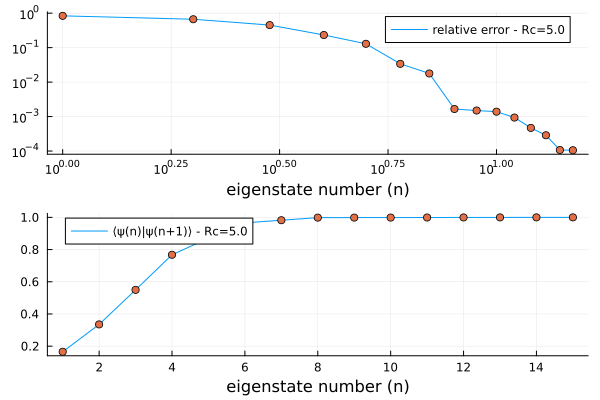

In [75]:
plot1=plot()
plot2=plot!(plot1,abs.(1.0 .- CheckConvergenceVector) ./ 1.0,label="relative error - Rc=$(round(Rc/Angstrom_to_au;digits=2))")
plot2=scatter!(plot1,abs.(1.0 .- CheckConvergenceVector) ./ 1.0,label="")
plot2=plot!(xlabel="eigenstate number (n)",ylabel="",yaxis=:log,xaxis=:log)

plot3=plot()
plot4=plot!(plot3,CheckConvergenceVector,label="⟨ψ(n)|ψ(n+1)⟩ - Rc=$(round(Rc/Angstrom_to_au;digits=2))")
plot4=scatter!(plot3,CheckConvergenceVector,label="")
plot4=plot!(xlabel="eigenstate number (n)",ylabel="")

display(plot(plot2,plot4,layout=(2,1)))

#### 5.2.2. Time evolution

In [128]:
t_start=0.0;t_end=200*Femtoseconds_to_au;           # tiempos adimensionales inicial y final
Δt=10.0; # time step
n_points=round(Int,abs(t_end-t_start)*(1.0/Δt))+1;  # number of dicrete time points

# total number of the wave function value to be saved in vtk format
t_end_vtk=10*Femtoseconds_to_au; # ¿hasta qué tiempo final quiero escribir datos?
n_save_vtk=round(Int,abs(t_end_vtk-t_start)*(1.0/Δt))+1; # calculo de la cantidad de puntos a escribir

time_vec=[t_start+Δt*(i-1) for i in 1:n_points];

In [129]:
println("Δt=$(Δt/Femtoseconds_to_au)[fs]; dim(time_vec)=$(length(time_vec))");
println("Escribimos $(n_save_vtk) datos hasta un tiempo final de $(t_end_vtk/Femtoseconds_to_au) [fs]")

Δt=0.218884[fs]; dim(time_vec)=915
Escribimos 47 datos hasta un tiempo final de 10.0 [fs]


In [130]:
𝛹ₓₜ=evolution_schrodinger_v2(𝛹ₓ₀,ϕH_2D,ϵH_2D,UHre_2D,dΩ_2D,time_vec);

In [79]:
for i in 1:20:n_points
    writevtk(Ω_2D,path_images*"evolution_wave_function_Rcvalue$(set_Rc_value)_$(lpad(i,3,'0'))",cellfields=["ρₓₜ" => real((𝛹ₓₜ[i])'*𝛹ₓₜ[i])]);
end

### 5.3. Calculate entropy

In [30]:
function Partial_probability_density(𝛹ₓ_vector,x₁_vector,x₂_vector,TrialSpace,Ω,dΩ)

    ρ_x₁_matrix=zeros(Float64,length(x₁_vector),length(𝛹ₓ_vector));
    ρ_x₂_matrix=zeros(Float64,length(x₂_vector),length(𝛹ₓ_vector));

    N₁=abs(x₁_vector[end]-x₁_vector[1]);
    N₂=abs(x₂_vector[end]-x₂_vector[1]);

    for t_index in 1:length(𝛹ₓ_vector)
        𝛹ₓᵢ=interpolate_everywhere(𝛹ₓ_vector[t_index],TrialSpace);
        𝛹ₓᵢ=𝛹ₓᵢ/norm_L2(𝛹ₓᵢ,dΩ);
        ρₓᵢ=real(𝛹ₓᵢ'*𝛹ₓᵢ);

        for x₁_index in 1:length(x₁_vector)
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₁_vector[x₁_index],1.0,1),Ω);
            δnorm=sum(integrate(δKroneckerGridap,dΩ));
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₁_vector[x₁_index],δnorm*N₂,1),Ω);
            ρ_x₁_matrix[x₁_index,t_index]=sum(integrate(ρₓᵢ*δKroneckerGridap,dΩ))
        end

        for x₂_index in 1:length(x₂_vector)
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₂_vector[x₂_index],1.0,2),Ω);
            δnorm=sum(integrate(δKroneckerGridap,dΩ));
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₂_vector[x₂_index],δnorm*N₁,2),Ω);
            ρ_x₂_matrix[x₂_index,t_index]=sum(integrate(ρₓᵢ*δKroneckerGridap,dΩ))
        end
    end
    return ρ_x₁_matrix,ρ_x₂_matrix;
end

Partial_probability_density (generic function with 1 method)

In [31]:
function Partial_probability_density_v2(𝛹ₓ_vector,x₁_vector,x₂_vector,TrialSpace,Ω,dΩ)

    ρ_x₁_matrix=zeros(Float64,length(𝛹ₓ_vector),length(x₁_vector));
    ρ_x₂_matrix=zeros(Float64,length(𝛹ₓ_vector),length(x₂_vector));

    N₁=abs(x₁_vector[end]-x₁_vector[1]);
    N₂=abs(x₂_vector[end]-x₂_vector[1]);

    for t_index in 1:length(𝛹ₓ_vector)
        𝛹ₓᵢ=interpolate_everywhere(𝛹ₓ_vector[t_index],TrialSpace);
        𝛹ₓᵢ=𝛹ₓᵢ/norm_L2(𝛹ₓᵢ,dΩ);
        ρₓᵢ=real(𝛹ₓᵢ'*𝛹ₓᵢ);

        for x₁_index in 1:length(x₁_vector)
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₁_vector[x₁_index],1.0,1),Ω);
            δnorm=sum(integrate(δKroneckerGridap,dΩ));
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₁_vector[x₁_index],δnorm*N₂,1),Ω);
            ρ_x₁_matrix[t_index,x₁_index]=sum(integrate(ρₓᵢ*δKroneckerGridap,dΩ))
        end

        for x₂_index in 1:length(x₂_vector)
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₂_vector[x₂_index],1.0,2),Ω);
            δnorm=sum(integrate(δKroneckerGridap,dΩ));
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₂_vector[x₂_index],δnorm*N₁,2),Ω);
            ρ_x₂_matrix[t_index,x₂_index]=sum(integrate(ρₓᵢ*δKroneckerGridap,dΩ))
        end
    end
    return ρ_x₁_matrix,ρ_x₂_matrix;
end

Partial_probability_density_v2 (generic function with 1 method)

----------------------------------------
Creamos las funciones delta de Dirac (aproximadas) en una sección aparte para poder visualizarlas en Visit y verificar si son buenas aproximaciones.

In [104]:
x₁_vector=DOF_r;x₂_vector=DOF_R;
N₁=abs(x₁_vector[end]-x₁_vector[1]);N₂=abs(x₂_vector[end]-x₂_vector[1]);
δKroneckerGridap₁=CellField(x->kronecker_deltax_Gridap_v2(x,0.0,1.0,1),Ω_2D);
δnorm₁=sum(integrate(δKroneckerGridap₁,dΩ_2D));
δKroneckerGridap₁=CellField(x->kronecker_deltax_Gridap_v2(x,0.0,δnorm₁*N₂,1),Ω_2D);
δKroneckerGridap₂=CellField(x->kronecker_deltax_Gridap_v2(x,0.0,1.0,2),Ω_2D);
δnorm₂=sum(integrate(δKroneckerGridap₂,dΩ_2D));
δKroneckerGridap₂=CellField(x->kronecker_deltax_Gridap_v2(x,0.0,δnorm₂*N₁,2),Ω_2D);
writevtk(Ω_2D,path_images*"DiracDeltaFunction",cellfields=["δx₁" => δKroneckerGridap₁,"δx₂" => δKroneckerGridap₂]);

------------------------------

In [80]:
DOF_r,DOF_R,pts=space_coord_2D(dom_2D,ΔrH,ΔRH);

In [131]:
electronic_ρ_matrix,nuclear_ρ_matrix=Partial_probability_density(𝛹ₓₜ,DOF_r,DOF_R,UHre_2D,Ω_2D,dΩ_2D);

In [84]:
electronic_ρ_matrix_v2,nuclear_ρ_matrix_v2=Partial_probability_density_v2(𝛹ₓₜ,DOF_r,DOF_R,UHre_2D,Ω_2D,dΩ_2D);

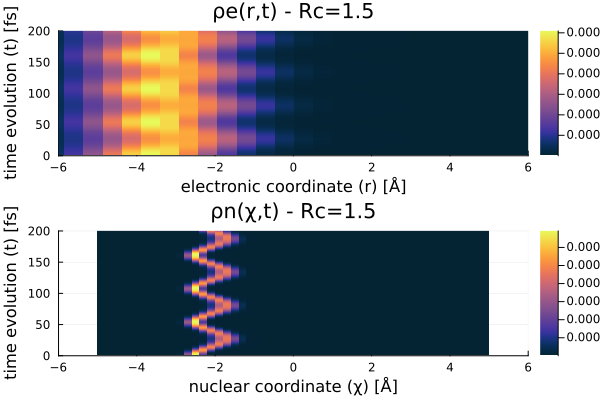

In [132]:
plot1=plot();
plot1=heatmap!(plot1,DOF_r./Angstrom_to_au, time_vec./Femtoseconds_to_au, transpose(electronic_ρ_matrix)./γ,
                c = :thermal,xlims=(-6,6))
plot1=plot!(plot1,xlabel="electronic coordinate (r) [Å]",ylabel="time evolution (t) [fs]")
plot1=plot!(plot1,title="ρe(r,t) - Rc=$(round(Rc/Angstrom_to_au,digits=2))")

plot2=plot();
plot2=heatmap!(plot2,DOF_R./(Angstrom_to_au*γ), time_vec./Femtoseconds_to_au, transpose(nuclear_ρ_matrix),
                c = :thermal,xlims=(-6,6))
plot2=plot!(plot2,xlabel="nuclear coordinate (χ) [Å]",ylabel="time evolution (t) [fs]")
plot2=plot!(plot2,title="ρn(χ,t) - Rc=$(round(Rc/Angstrom_to_au,digits=2))")

display(plot(plot1,plot2,layout=(2,1)))

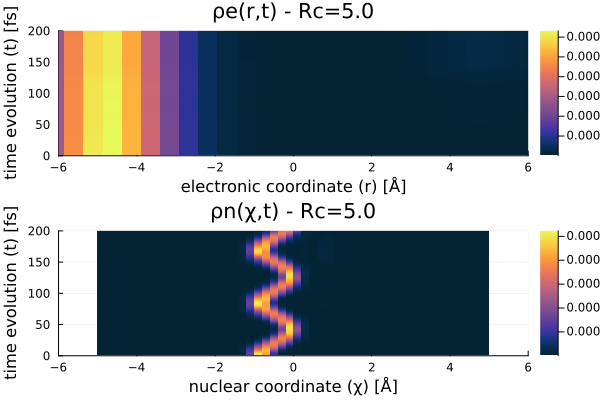

In [67]:
plot1=plot();
plot1=heatmap!(plot1,DOF_r./Angstrom_to_au, time_vec./Femtoseconds_to_au, transpose(electronic_ρ_matrix)./γ,
                c = :thermal,xlims=(-6,6))
plot1=plot!(plot1,xlabel="electronic coordinate (r) [Å]",ylabel="time evolution (t) [fs]")
plot1=plot!(plot1,title="ρe(r,t) - Rc=$(round(Rc/Angstrom_to_au,digits=2))")

plot2=plot();
plot2=heatmap!(plot2,DOF_R./(Angstrom_to_au*γ), time_vec./Femtoseconds_to_au, transpose(nuclear_ρ_matrix),
                c = :thermal,xlims=(-6,6))
plot2=plot!(plot2,xlabel="nuclear coordinate (χ) [Å]",ylabel="time evolution (t) [fs]")
plot2=plot!(plot2,title="ρn(χ,t) - Rc=$(round(Rc/Angstrom_to_au,digits=2))")

display(plot(plot1,plot2,layout=(2,1)))

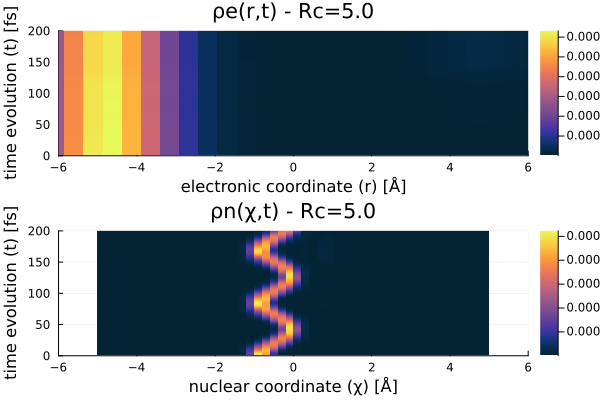

In [85]:
plot1=plot();
plot1=heatmap!(plot1,DOF_r./Angstrom_to_au, time_vec./Femtoseconds_to_au,electronic_ρ_matrix_v2./γ,
                c = :thermal,xlims=(-6,6))
plot1=plot!(plot1,xlabel="electronic coordinate (r) [Å]",ylabel="time evolution (t) [fs]")
plot1=plot!(plot1,title="ρe(r,t) - Rc=$(round(Rc/Angstrom_to_au,digits=2))")

plot2=plot();
plot2=heatmap!(plot2,DOF_R./(Angstrom_to_au*γ), time_vec./Femtoseconds_to_au,nuclear_ρ_matrix_v2,
                c = :thermal,xlims=(-6,6))
plot2=plot!(plot2,xlabel="nuclear coordinate (χ) [Å]",ylabel="time evolution (t) [fs]")
plot2=plot!(plot2,title="ρn(χ,t) - Rc=$(round(Rc/Angstrom_to_au,digits=2))")

display(plot(plot1,plot2,layout=(2,1)))

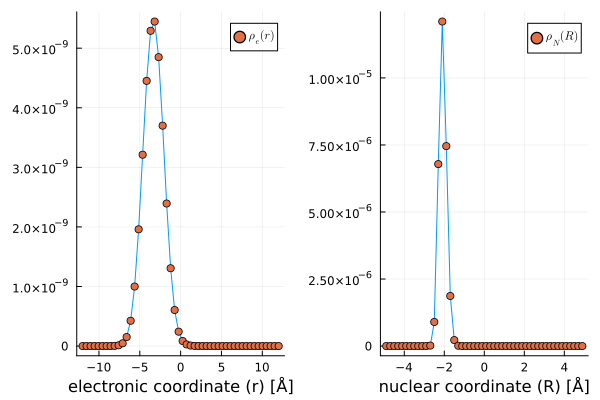

In [35]:
plot1=plot();
plot2=plot!(plot1,DOF_r./Angstrom_to_au,electronic_ρ_matrix[:,end]./γ,label="")
plot2=scatter!(plot1,DOF_r./Angstrom_to_au,electronic_ρ_matrix[:,end]./γ,label="\$ρ_{e}(r)\$")
plot2=plot!(xlabel="electronic coordinate (r) [Å]")

plot3=plot();
plot4=plot!(plot3,DOF_R./(Angstrom_to_au*γ),nuclear_ρ_matrix[:,end],label="")
plot4=scatter!(plot3,DOF_R./(Angstrom_to_au*γ),nuclear_ρ_matrix[:,end],label="\$ρ_{N}(R)\$")
plot4=plot!(xlabel="nuclear coordinate (R) [Å]")

display(plot(plot2,plot4,layout=2))

In [36]:
function densification_xvec(x_vec_old,densification)
    n_old=length(x_vec_old); # number of points elements
    Δx_old=abs(x_vec_old[end]-x_vec_old[1])*(1.0/(n_old-1));
    x_vec_new=[x_vec_old[1]+Δx_old*(1.0/densification)*(i-1)  for i in 1:(n_old-1)*densification+1];
    return x_vec_new;
end

function Trapezoidal_Integration_Method(x_vec,fx_vec)
    dim_x=length(x_vec);

    coef_vec=copy(x_vec);
    coef_vec[1]=1.0;
    coef_vec[2:(dim_x-1)].=2.0;
    coef_vec[end]=1.0;

    function_vec=copy(x_vec);
    function_vec[1]=fx_vec[1];
    function_vec[2:(dim_x-1)].=fx_vec[2:(dim_x-1)];
    function_vec[end]=fx_vec[end];

    Δx=abs(x_vec[2]-x_vec[1]); # válido para cuando Δx es constante

    return 0.5*Δx*(transpose(function_vec)*coef_vec);
end


function Trapezoidal_Integration_Method_v2(x_vec_old,fx_vec_old;TypeInterpolation=LagrangeInterpolation,densification=2)

    fx_vec=TypeInterpolation(fx_vec_old,x_vec_old);
    x_vec=densification_xvec(x_vec_old,densification)

    dim_x=length(x_vec);

    coef_vec=copy(x_vec);
    coef_vec[1]=1.0;
    coef_vec[2:(dim_x-1)] .= 2.0;
    coef_vec[end]=1.0;

    function_vec=copy(x_vec);
    function_vec[1]=fx_vec(x_vec[1]);

    for i in 2:(dim_x-1)
        function_vec[i]=fx_vec(x_vec[i]);
    end

    function_vec[end]=fx_vec(x_vec[end]);

    Δx=abs(x_vec[2]-x_vec[1]); # válido para cuando Δx es constante

    return 0.5*Δx*(transpose(function_vec)*coef_vec);

end

function Simpson_Integration_Method(x_vec,fx_vec)
    dim_x=length(x_vec);

    coef_vec=copy(x_vec);
    coef_vec[1]=1.0;
    coef_vec[end]=1.0;

    function_vec=copy(x_vec);
    function_vec[1]=fx_vec[1];
    function_vec[2:(dim_x-1)].=fx_vec[2:(length(x_vec)-1)];
    function_vec[end]=fx_vec[end];

    Δx=abs(x_vec[2]-x_vec[1]); # válido para cuando Δx es constante

    # cantidad de puntos es par => Simpson 1/3
    if (mod(dim_x,2)==0)
        for i in 2:(length(x_vec)-1);
            if (mod(i,2)==0)    # ìndice múltiplo de 2
                coef_vec[i]=4.0;
            else
                coef_vec[i]=2.0;
            end
        end
        return (1.0/3.0)*Δx*(transpose(function_vec)*coef_vec);
    # cantidad de puntos es par => Simpson 3/8
    else
        for i in 2:(length(x_vec)-1);
            if (mod(i,3)==0)    # ìndice múltiplo de 3
                coef_vec[i]=2.0;
            else
                coef_vec[i]=3.0;
            end
        end
        return (3.0/8.0)*Δx*(transpose(function_vec)*coef_vec);
    end
end

Simpson_Integration_Method (generic function with 1 method)

### Testing de los integradores

In [10]:
x_start=-10.0;x_end=10.0;
nx=100;Δx=abs(x_end-x_start)/(nx-1);
x_vec=[x_start+Δx*(i-1) for i in 1:nx];

0.0033987023691179744
0.06055187147375488


3.764614701368741e-5


0.0003192914978305737


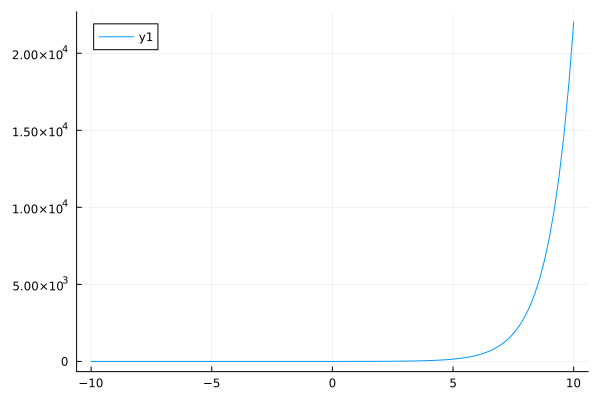

In [13]:
exact_value=2.0*sinh(10)
fx_vec = exp.(x_vec);
println(abs(exact_value-Trapezoidal_Integration_Method(x_vec,fx_vec))/exact_value)
println(abs(exact_value-Simpson_Integration_Method(x_vec,fx_vec))/exact_value)
println(abs(exact_value-Trapezoidal_Integration_Method_v2(x_vec,fx_vec;TypeInterpolation=AkimaInterpolation,densification=200))/exact_value)
println(abs(exact_value-Trapezoidal_Integration_Method_v2(x_vec,fx_vec;TypeInterpolation=CubicSpline,densification=200))/exact_value)
plot(x_vec,fx_vec)

0.08520687417581162
0.03690692746883697
0.0466976354115595
0.05599328122237978


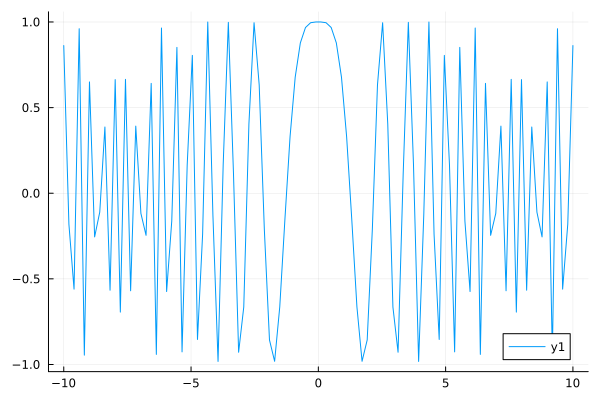

In [14]:
exact_value=1.20225
fx_vec = cos.(x_vec .^ 2);
println(abs(exact_value-Trapezoidal_Integration_Method(x_vec,fx_vec))/exact_value)
println(abs(exact_value-Simpson_Integration_Method(x_vec,fx_vec))/exact_value)
println(abs(exact_value-Trapezoidal_Integration_Method_v2(x_vec,fx_vec;TypeInterpolation=AkimaInterpolation,densification=200))/exact_value)
println(abs(exact_value-Trapezoidal_Integration_Method_v2(x_vec,fx_vec;TypeInterpolation=CubicSpline,densification=200))/exact_value)
plot(x_vec,fx_vec)

1.9895196601282807e-15
0.0003850226384163591
3.232969447708456e-13
6.8212102632969615e-15


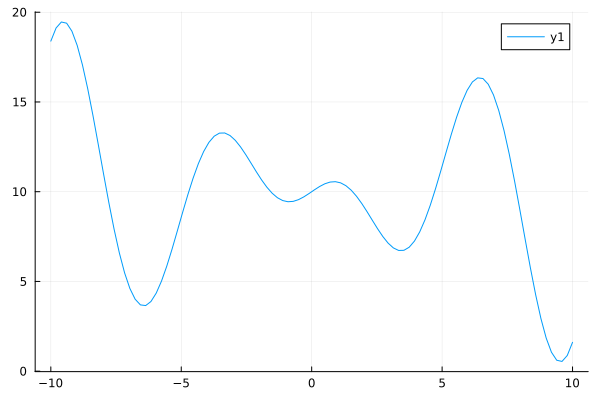

In [15]:
exact_value = 200.0
fx_vec = 10.0 .+ cos.(x_vec) .* x_vec;
println(abs(exact_value-Trapezoidal_Integration_Method(x_vec,fx_vec))/exact_value)
println(abs(exact_value-Simpson_Integration_Method(x_vec,fx_vec))/exact_value)
println(abs(exact_value-Trapezoidal_Integration_Method_v2(x_vec,fx_vec;TypeInterpolation=AkimaInterpolation,densification=200))/exact_value)
println(abs(exact_value-Trapezoidal_Integration_Method_v2(x_vec,fx_vec;TypeInterpolation=CubicSpline,densification=2))/exact_value)
plot(x_vec,fx_vec)

### Funciones que computan las entropías reducidas

In [42]:
function integration_argument_diff_shannon_entropy(ρ_x_vector)
    return ρ_x_vector .* log.(ρ_x_vector)
end

function Reduced_TimeIndependet_Diff_Shannon_Entropy(x_vec,ρ_x_vector;IntType="trapezoidal")
    if (IntType=="trapezoidal")
        return Trapezoidal_Integration_Method(x_vec,integration_argument_diff_shannon_entropy(ρ_x_vector))
    elseif (IntType=="improved_trapezoidal")
        return Trapezoidal_Integration_Method_v2(x_vec,integration_argument_diff_shannon_entropy(ρ_x_vector);densification=4)
    elseif (IntType=="simpson")
        return Simpson_Integration_Method(x_vec,integration_argument_diff_shannon_entropy(ρ_x_vector))
    end
end

function Reduced_TimeDependent_Diff_Shannon_Entropy(x_vec,ρ_x_matrix;IntType="trapezoidal")
    Sx_vector=Vector{Float64}(undef,length(ρ_x_matrix[1,:]));
    for i in 1:length(Sx_vector)
        Sx_vector[i]=Reduced_TimeIndependet_Diff_Shannon_Entropy(x_vec,ρ_x_matrix[:,i];IntType=IntType)
    end
    return -1.0 .* Sx_vector;
end

Reduced_TimeDependent_Diff_Shannon_Entropy (generic function with 1 method)

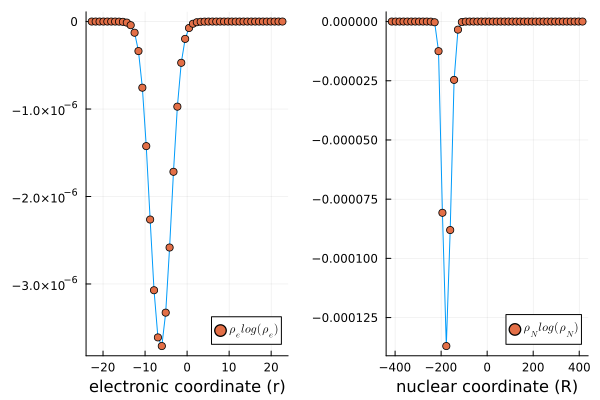

In [39]:
plot1=plot();
plot2=plot!(plot1,DOF_r,integration_argument_diff_shannon_entropy(electronic_ρ_matrix[:,end]),label="")
plot2=scatter!(plot1,DOF_r,integration_argument_diff_shannon_entropy(electronic_ρ_matrix[:,end]),label="\$ρ_{e}log(ρ_{e})\$")
plot2=plot!(xlabel="electronic coordinate (r)")

plot3=plot();
plot4=plot!(plot3,DOF_R,integration_argument_diff_shannon_entropy(nuclear_ρ_matrix[:,end]),label="")
plot4=scatter!(plot3,DOF_R,integration_argument_diff_shannon_entropy(nuclear_ρ_matrix[:,end]),label="\$ρ_{N}log(ρ_{N})\$")
plot4=plot!(xlabel="nuclear coordinate (R)")

display(plot(plot2,plot4,layout=2))

In [85]:
total_S_2D=TimeIndependet_Diff_Shannon_Entropy(𝛹ₓₜ,UHre_2D,dΩ_2D)./γ;
electronic_S=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_r,electronic_ρ_matrix./γ)
nuclear_S=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_R,nuclear_ρ_matrix)./γ
mutual_info=electronic_S .+ nuclear_S .- total_S_2D;

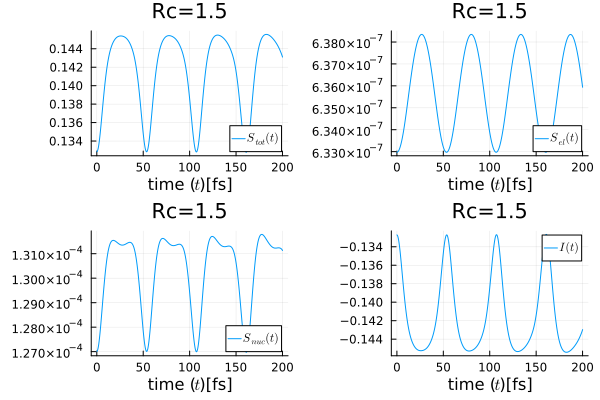

In [41]:
plot1=plot();
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,total_S_2D,label="\$S_{tot}(t)\$");
plot2=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot();
plot4=plot!(plot3,time_vec./Femtoseconds_to_au,electronic_S,label="\$S_{el}(t)\$");
plot4=plot!(xlabel="time (\$t\$)[fs]")

plot5=plot();
plot6=plot!(plot5,time_vec./Femtoseconds_to_au,nuclear_S,label="\$S_{nuc}(t)\$");
plot6=plot!(xlabel="time (\$t\$)[fs]")

plot7=plot();
plot8=plot!(plot7,time_vec./Femtoseconds_to_au,mutual_info,label="\$I(t)\$");
plot8=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot(plot2,plot4,plot6,plot8,layout=(2,2),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))");
display(plot3)

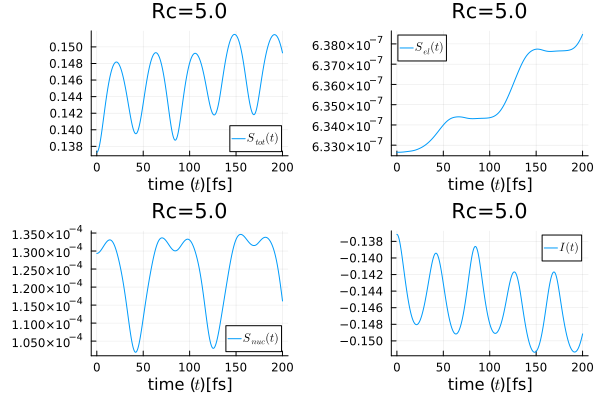

In [86]:
plot1=plot();
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,total_S_2D,label="\$S_{tot}(t)\$");
plot2=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot();
plot4=plot!(plot3,time_vec./Femtoseconds_to_au,electronic_S,label="\$S_{el}(t)\$");
plot4=plot!(xlabel="time (\$t\$)[fs]")

plot5=plot();
plot6=plot!(plot5,time_vec./Femtoseconds_to_au,nuclear_S,label="\$S_{nuc}(t)\$");
plot6=plot!(xlabel="time (\$t\$)[fs]")

plot7=plot();
plot8=plot!(plot7,time_vec./Femtoseconds_to_au,mutual_info,label="\$I(t)\$");
plot8=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot(plot2,plot4,plot6,plot8,layout=(2,2),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))");
display(plot3)

In [87]:
electronic_S_simpson=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_r,electronic_ρ_matrix./γ;IntType="simpson")
nuclear_S_simpson=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_R,nuclear_ρ_matrix;IntType="simpson")./γ
mutual_info_simpson=electronic_S_simpson .+ nuclear_S_simpson .- total_S_2D;

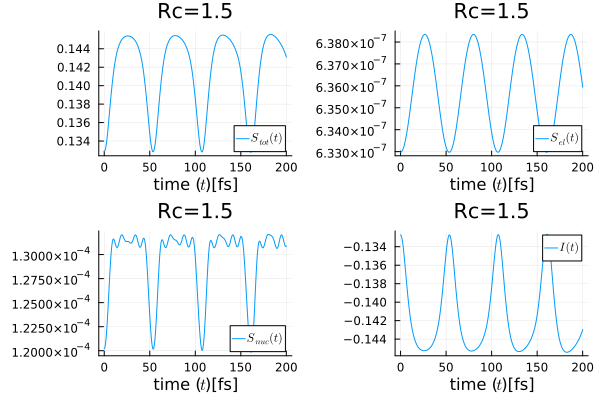

In [44]:
plot1=plot();
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,total_S_2D,label="\$S_{tot}(t)\$");
plot2=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot();
plot4=plot!(plot3,time_vec./Femtoseconds_to_au,electronic_S_simpson,label="\$S_{el}(t)\$");
plot4=plot!(xlabel="time (\$t\$)[fs]")

plot5=plot();
plot6=plot!(plot5,time_vec./Femtoseconds_to_au,nuclear_S_simpson,label="\$S_{nuc}(t)\$");
plot6=plot!(xlabel="time (\$t\$)[fs]")

plot7=plot();
plot8=plot!(plot7,time_vec./Femtoseconds_to_au,mutual_info_simpson,label="\$I(t)\$");
plot8=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot(plot2,plot4,plot6,plot8,layout=(2,2),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))");
display(plot3)

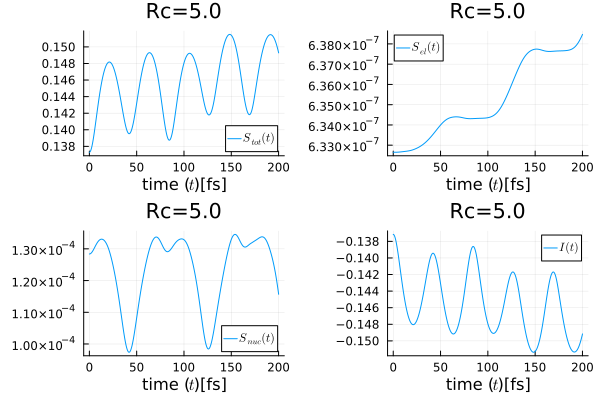

In [88]:
plot1=plot();
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,total_S_2D,label="\$S_{tot}(t)\$");
plot2=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot();
plot4=plot!(plot3,time_vec./Femtoseconds_to_au,electronic_S_simpson,label="\$S_{el}(t)\$");
plot4=plot!(xlabel="time (\$t\$)[fs]")

plot5=plot();
plot6=plot!(plot5,time_vec./Femtoseconds_to_au,nuclear_S_simpson,label="\$S_{nuc}(t)\$");
plot6=plot!(xlabel="time (\$t\$)[fs]")

plot7=plot();
plot8=plot!(plot7,time_vec./Femtoseconds_to_au,mutual_info_simpson,label="\$I(t)\$");
plot8=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot(plot2,plot4,plot6,plot8,layout=(2,2),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))");
display(plot3)

Usamos un paquete de interpolación para utilizar la integración dentro de Gridap

In [45]:
function InterpolationFunction(x,x_component,fx_vector,x_vector)
    f=InterpolationFunction_v2(fx_vector,x_vector)
    return f(x[x_component])
end

function InterpolationFunction_v2(fx_vector,x_vector;TypeInterpolation=LagrangeInterpolation)
    f = TypeInterpolation(fx_vector,x_vector)
    return f
end

function ReducedEntropy(x_component,ρx_matrix,x_vector,Ω,dΩ)

    (x_component==1) ? (complement_x_component=2) : (complement_x_component=1)

    Sx_vector=Vector{Float64}(undef,length(ρx_matrix[1,:]));

    N₁=abs(x_vector[end]-x_vector[1]);

    for time_index in 1:length(ρx_matrix[1,:])
        fx_vector=electronic_ρ_matrix[:,time_index] .* log.(electronic_ρ_matrix[:,time_index]);
        fx_InterpolationGridap=CellField(x->InterpolationFunction(x,x_component,fx_vector,x_vector),Ω);

        δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,0.0,1.0,complement_x_component),Ω);
        δnorm=sum(integrate(δKroneckerGridap,dΩ));
        δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,0.0,δnorm*N₁,complement_x_component),Ω);

        Sx_vector[time_index]=-sum(∫(fx_InterpolationGridap*δKroneckerGridap)*dΩ)
    end

    return Sx_vector;
    
end

ReducedEntropy (generic function with 1 method)

In [89]:
electronic_S_interpolation=ReducedEntropy(1,electronic_ρ_matrix./γ,DOF_r,Ω_2D,dΩ_2D);
nuclear_S_interpolation=ReducedEntropy(2,nuclear_ρ_matrix,DOF_R,Ω_2D,dΩ_2D)./γ;
mutual_info_interpolation=electronic_S.+nuclear_S.-total_S_2D;

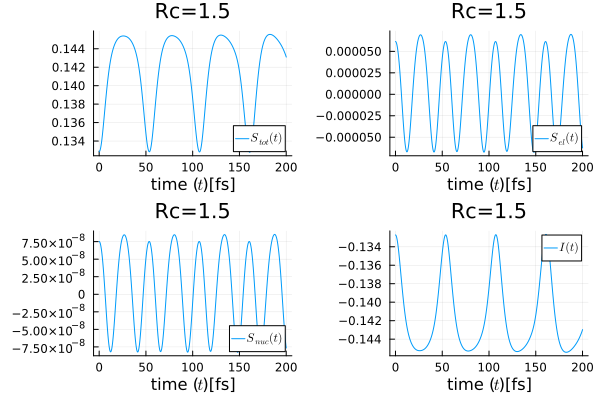

In [48]:
plot1=plot();
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,total_S_2D,label="\$S_{tot}(t)\$");
plot2=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot();
plot4=plot!(plot3,time_vec./Femtoseconds_to_au,electronic_S_interpolation,label="\$S_{el}(t)\$");
plot4=plot!(xlabel="time (\$t\$)[fs]");

plot5=plot();
plot6=plot!(plot5,time_vec./Femtoseconds_to_au,nuclear_S_interpolation,label="\$S_{nuc}(t)\$");
plot6=plot!(xlabel="time (\$t\$)[fs]");

plot7=plot();
plot8=plot!(plot7,time_vec./Femtoseconds_to_au,mutual_info,label="\$I(t)\$");
plot8=plot!(xlabel="time (\$t\$)[fs]")

display(plot(plot2,plot4,plot6,plot8,layout=(2,2),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))"))

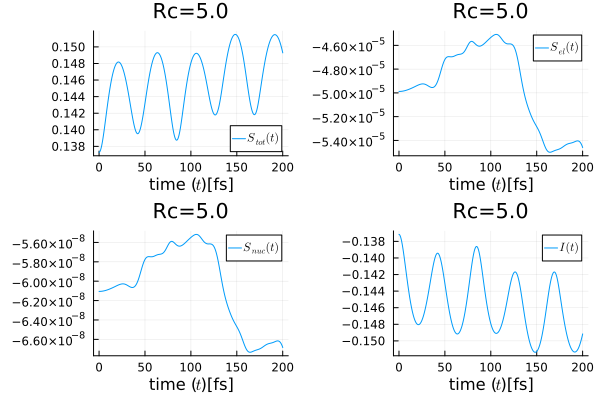

In [90]:
plot1=plot();
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,total_S_2D,label="\$S_{tot}(t)\$");
plot2=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot();
plot4=plot!(plot3,time_vec./Femtoseconds_to_au,electronic_S_interpolation,label="\$S_{el}(t)\$");
plot4=plot!(xlabel="time (\$t\$)[fs]");

plot5=plot();
plot6=plot!(plot5,time_vec./Femtoseconds_to_au,nuclear_S_interpolation,label="\$S_{nuc}(t)\$");
plot6=plot!(xlabel="time (\$t\$)[fs]");

plot7=plot();
plot8=plot!(plot7,time_vec./Femtoseconds_to_au,mutual_info,label="\$I(t)\$");
plot8=plot!(xlabel="time (\$t\$)[fs]")

display(plot(plot2,plot4,plot6,plot8,layout=(2,2),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))"))

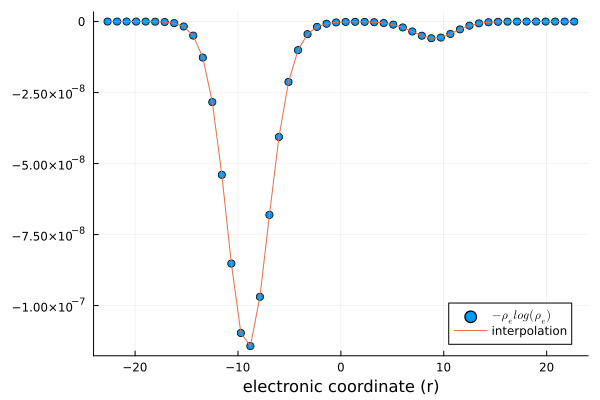

In [91]:
fx_vector=(electronic_ρ_matrix[:,end]./γ) .* log.(electronic_ρ_matrix[:,end]./γ);

plot1=plot();
plot2=scatter!(plot1,DOF_r,integration_argument_diff_shannon_entropy(electronic_ρ_matrix[:,end]./γ),label="\$-ρ_{e}log(ρ_{e})\$")
plot2=plot!(plot1,DOF_r,InterpolationFunction_v2(fx_vector,DOF_r).(DOF_r),label="interpolation")
plot2=plot!(xlabel="electronic coordinate (r)")

### Calculamos valores de expectación de la posición

In [113]:
function xfunction(x,x_component)
    return x[x_component]
end

function x²function(x,x_component)
    return pow(x[x_component],2)
end

function xvariancefunction(x,x₀,x_component)
    return pow(x[x_component]-x₀,2)
end

function position_expectation_value(𝛹ₓₜ,Ω,dΩ,TrialSpace,x_component)
    xGridap=CellField(x->xfunction(x,x_component),Ω);
    x_ExpValue_vector=zeros(Float64,length(𝛹ₓₜ));

    for time_index in 1:length(𝛹ₓₜ)
        𝛹ₓₜⁱ=interpolate_everywhere(𝛹ₓₜ[time_index],TrialSpace)
        # ojo! tomamos la parte real porque se trata de la coord. espacial, pero puede ser complejo
        x_ExpValue_vector[time_index]=real(sum(∫((𝛹ₓₜⁱ)'*xGridap*𝛹ₓₜⁱ)*dΩ))
    end

    return x_ExpValue_vector;
end

function position_variance(𝛹ₓₜ,Ω,dΩ,TrialSpace,x_component)
    x_variance_vector=zeros(Float64,length(𝛹ₓₜ));
    x₀_vector=position_expectation_value(𝛹ₓₜ,Ω,dΩ,TrialSpace,x_component);

    for time_index in 1:length(𝛹ₓₜ)
        IntegralFactorGridap=CellField(x->xvariancefunction(x,x₀_vector[time_index],x_component),Ω);
        𝛹ₓₜⁱ=interpolate_everywhere(𝛹ₓₜ[time_index],TrialSpace)
        # ojo! tomamos la parte real porque se trata de la coord. espacial, pero puede ser complejo
        x_variance_vector[time_index]=sqrt(real(sum(∫(conj(𝛹ₓₜⁱ)*IntegralFactorGridap*𝛹ₓₜⁱ)*dΩ)))
    end

    return x_variance_vector;
end

function position²_expectation_value(𝛹ₓₜ,Ω,dΩ,TrialSpace,x_component)
    x²Gridap=CellField(x->x²function(x,x_component),Ω);
    x²_ExpValue_vector=zeros(Float64,length(𝛹ₓₜ));

    for time_index in 1:length(𝛹ₓₜ)
        𝛹ₓₜⁱ=interpolate_everywhere(𝛹ₓₜ[time_index],TrialSpace)
        # ojo! tomamos la parte real porque se trata de la coord. espacial, pero puede ser complejo
        x²_ExpValue_vector[time_index]=real(sum(∫((𝛹ₓₜⁱ)'*x²Gridap*𝛹ₓₜⁱ)*dΩ))
    end

    return x²_ExpValue_vector;
end

position²_expectation_value (generic function with 1 method)

In [133]:
r_ExpValue=position_expectation_value(𝛹ₓₜ,Ω_2D,dΩ_2D,UHre_2D,1);
R_ExpValue=position_expectation_value(𝛹ₓₜ,Ω_2D,dΩ_2D,UHre_2D,2);

Esta opción no nos dá bien, es más, el resultado es igual al valor de expectación de la posición lo cual claramente no puede ser

In [134]:
r_variance=position_expectation_value(𝛹ₓₜ,Ω_2D,dΩ_2D,UHre_2D,1);
R_variance=position_expectation_value(𝛹ₓₜ,Ω_2D,dΩ_2D,UHre_2D,2);

Por ello probamos calcular la varianza de la siguiente manera

In [135]:
r²_ExpValue=position²_expectation_value(𝛹ₓₜ,Ω_2D,dΩ_2D,UHre_2D,1);
R²_ExpValue=position²_expectation_value(𝛹ₓₜ,Ω_2D,dΩ_2D,UHre_2D,2);

r_variance_v2=sqrt.(r²_ExpValue.-(r_ExpValue.*r_ExpValue));
R_variance_v2=sqrt.(R²_ExpValue.-(R_ExpValue.*R_ExpValue));

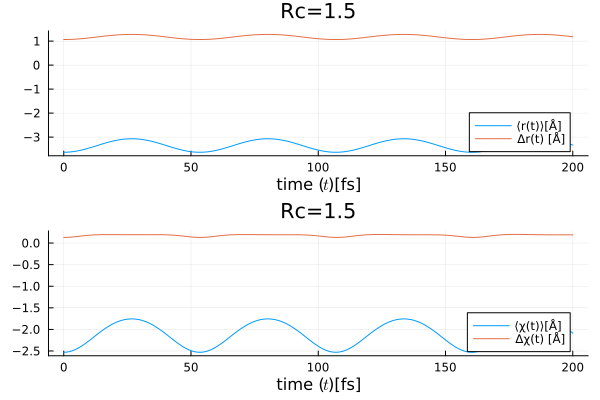

In [136]:
plot1=plot();
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,r_ExpValue./Angstrom_to_au,label="⟨r(t)⟩[Å]")
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,r_variance_v2./Angstrom_to_au,label="Δr(t) [Å]")
plot2=plot!(xlabel="time (\$t\$)[fs]",title="Rc=$(round(Rc/Angstrom_to_au,digits=2))")

plot3=plot();
plot4=plot!(plot3,time_vec./Femtoseconds_to_au,R_ExpValue./(Angstrom_to_au*γ),label="⟨χ(t)⟩[Å]")
plot4=plot!(plot3,time_vec./Femtoseconds_to_au,R_variance_v2./(Angstrom_to_au*γ),label="Δχ(t) [Å]")
plot4=plot!(xlabel="time (\$t\$)[fs]",title="Rc=$(round(Rc/Angstrom_to_au,digits=2))")

display(plot(plot2,plot4,layout=(2,1)))

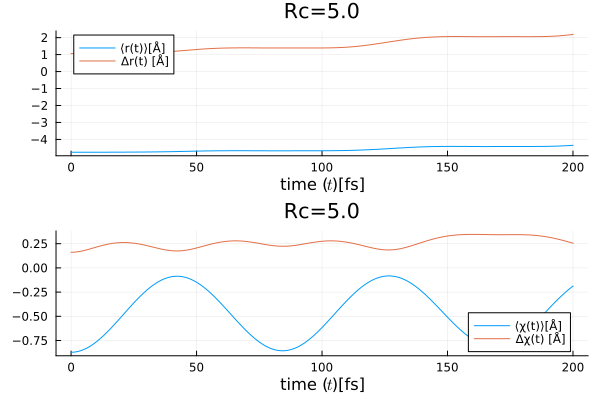

In [118]:
plot1=plot();
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,r_ExpValue./Angstrom_to_au,label="⟨r(t)⟩[Å]")
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,r_variance_v2./Angstrom_to_au,label="Δr(t) [Å]")
plot2=plot!(xlabel="time (\$t\$)[fs]",title="Rc=$(round(Rc/Angstrom_to_au,digits=2))")

plot3=plot();
plot4=plot!(plot3,time_vec./Femtoseconds_to_au,R_ExpValue./(Angstrom_to_au*γ),label="⟨χ(t)⟩[Å]")
plot4=plot!(plot3,time_vec./Femtoseconds_to_au,R_variance_v2./(Angstrom_to_au*γ),label="Δχ(t) [Å]")
plot4=plot!(xlabel="time (\$t\$)[fs]",title="Rc=$(round(Rc/Angstrom_to_au,digits=2))")

display(plot(plot2,plot4,layout=(2,1)))